# AlexNet

This notebook is an implement of [___ImageNet Classification with Deep Convolutinal Neural Networks___](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) by Krizhevsky et al. The original model was trained for ImageNet dataset, but in this notebook we fine-tuned it for Cifar 10 dataset, which is a relatively smaller dataset and is better to store on Google Colab. 

We first need to install all the dependent libraries in the session.

In [ ]:
!pip install tensorflow tensorflow-datasets keras-tuner matplotlib sklearn

     |████████████████████████████████| 97 kB 5.2 MB/s 


This is function that constructs an AlexNet model. The structure of the model is almost same with the original paper, but the kernel size and strides are adjusted to fit the smaller pictures of Cifar 10. We define two variables, weight_decay and dropout_rate, as the hyperparameters of the model for kernel regularization and dropout layer, respectively.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2

def createAlexNet(weight_decay, dropout_rate):
    model = tf.keras.Sequential([
        Conv2D(input_shape = (32, 32, 3), kernel_size = (3, 3), filters = 48, strides = 1, padding = "same",
            activation = "relu", kernel_regularizer = l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2, 2), padding = "same"),
        Conv2D(kernel_size = (3, 3), filters = 128, padding = "same", activation = "relu",
            kernel_regularizer = l2(weight_decay)),
        BatchNormalization(),
        Conv2D(kernel_size = (3, 3), filters = 192, padding = "same", activation = "relu",
            kernel_regularizer = l2(weight_decay)),
        Conv2D(kernel_size = (3, 3), filters = 192, padding = "same", activation = "relu",
            kernel_regularizer = l2(weight_decay)),
        Conv2D(kernel_size = (3, 3), filters = 128, padding = "same", activation = "relu",
            kernel_regularizer = l2(weight_decay)),
        BatchNormalization(),
        Flatten(),
        Dropout(dropout_rate),
        Activation(activation = "relu"),
        Dropout(dropout_rate),
        Activation(activation = "relu"),
        Dense(10, activation = "softmax")
    ])

    return model

In this part of the program, we get the Cifar 10 dataset using tensorflow dataset and separate it into training set and test set.

In [ ]:
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

def get_data():
    data, label = tfds.as_numpy(
        tfds.load("cifar10", split = "train", shuffle_files = True, as_supervised = True, batch_size = -1))

    return train_test_split(data, label, test_size = .2, random_state = 4)

This part of the program aims to seek for the best parameter for our model. We use Keras Tuner and Hyperband as the library and the function for searching. The best hyperparameters for the model is also shown.

In [ ]:
from keras_tuner.tuners import Hyperband

def build_model(hp):
    model = createAlexNet(hp.Float("weight_decay", 0, 2, step = .05, default = 1.6),
        hp.Float("dropout_rate", 0.1, 0.9, step = .1, default = .5));
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4, 1e-5])),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])

    return model

def search_model(train_data, train_label, overWrite = False):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

    tuner = Hyperband(build_model, objective = "val_accuracy", max_epochs = 100, hyperband_iterations = 2,
        directory = "alexnet", project_name = "AlexNet", overwrite = overWrite)
    tuner.search(train_data, train_label, epochs = 100, validation_split = .2, callbacks = [early_stop])

    print("Weight decay: ", tuner.get_best_hyperparameters()[0].get("weight_decay"))
    print("Dropout rate: ", tuner.get_best_hyperparameters()[0].get("dropout_rate"))
    print("Learning rate: ", tuner.get_best_hyperparameters()[0].get("learning_rate"))

    model = tuner.get_best_models(1)[0]

    return model

We start the training by acquiring training data and label. Then, we search for the best model using the function defined above.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

train_data, _, train_label, _ = get_data()

# Please remember to set overWrite = True here if you want to search for new hyperparameters with different attributes!
model = search_model(train_data, train_label)

Trial 7 Complete [00h 18m 22s]
val_accuracy: 0.7742499709129333

Best val_accuracy So Far: 0.7868750095367432
Total elapsed time: 01h 14m 31s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Weight decay:  0.1
Dropout rate:  0.2
Learning rate:  1e-05


This part trains the best model we get on Cifar 10 dataset. We store the best weights of each training epochs on drive so that we can continue training even if the session disconnects. We also store searching results and training weights in case the process takes too much time or the session crashes accidentally. We show the result of the training process with a graph about the training and validation accuracy for each epoch.

Epoch 1/50
500/500 [==============================] - 10s 18ms/step - loss: 23.3051 - accuracy: 0.4143 - val_loss: 16.4012 - val_accuracy: 0.5395
Epoch 2/50
500/500 [==============================] - 9s 18ms/step - loss: 12.0613 - accuracy: 0.5863 - val_loss: 8.8325 - val_accuracy: 0.5815
Epoch 3/50
500/500 [==============================] - 9s 18ms/step - loss: 6.6333 - accuracy: 0.6658 - val_loss: 5.2278 - val_accuracy: 0.6284
Epoch 4/50
500/500 [==============================] - 9s 18ms/step - loss: 4.0311 - accuracy: 0.7127 - val_loss: 3.5035 - val_accuracy: 0.6316
Epoch 5/50
500/500 [==============================] - 9s 18ms/step - loss: 2.7125 - accuracy: 0.7314 - val_loss: 2.4934 - val_accuracy: 0.6712
Epoch 6/50
500/500 [==============================] - 9s 17ms/step - loss: 2.0015 - accuracy: 0.7440 - val_loss: 2.0140 - val_accuracy: 0.6615
Epoch 7/50
500/500 [==============================] - 9s 17ms/step - loss: 1.5961 - accuracy: 0.7553 - val_loss: 1.8290 - val_accuracy: 0.

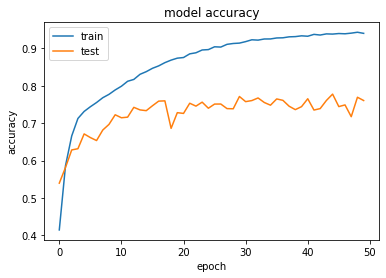

In [ ]:
# Set a checkpoint to save weights
cp = tf.keras.callbacks.ModelCheckpoint("weights", monitor = "loss", verbose = 1, save_best_only = True, mode = "auto")

model = createAlexNet(0.05, .2)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = .0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])

# We can use the existing data if the training process has started
# model.load_weights("weights")

history = model.fit(train_data, train_label, epochs = 50, validation_split = .2, batch_size = 64)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

Here we test our model on test set and show how AlexNet predicts on sample images in the test set.

Test Accuracy: 77.48%


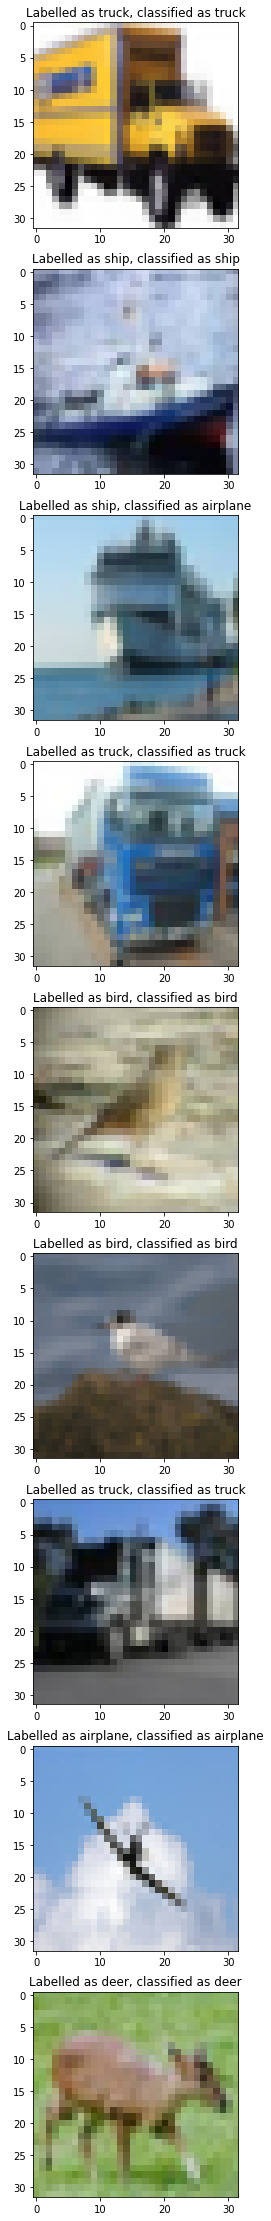

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

_, test_data, _, test_label = get_data()

pred = np.argmax(model.predict(test_data), axis = 1)

print("Test Accuracy: {:.2%}".format(np.sum(pred == test_label) / len(test_label)))

sample_data = test_data[: 9]
sample_label = test_label[: 9]

fig = plt.figure(figsize = (10, 40))

for i in range(len(sample_data)):
    ax = fig.add_subplot(911 + i)
    ax.imshow(test_data[i])

    ax.set_title("Labelled as " + labels[int(sample_label[i])] + ", classified as " + labels[int(pred[i])])